# **Eocene OIFS Data Generation & Sanity Check Notebook**

This notebook runs every step of the `EoceneOIFS` pipeline and performs
sanity-check plotting for each modified field.

## 0. Setup

In [1]:
import os
import xarray as xr
import numpy as np
from cdo import Cdo
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import tempfile

from eocene_creator import EoceneOIFS

cdo = Cdo()


## 1. Instantiate EoceneOIFS
Modify paths as needed.

In [2]:
eocene = EoceneOIFS(
    idir="/lus/h2resw01/hpcperm//ecme3497/ECE-DATA",
    odir="/lus/h2resw01/hpcperm/ecme3497/ECE-DATA-EOC",
    herold="/lus/h2resw01/hpcperm/ecme3497/herold-et-al-2014/Supp",
    startdate="17000101"
)

Define sanity check helper

In [3]:
# Sanity check helper
def plot_compare(original, modified, title):
    fig, axes = plt.subplots(1, 2, figsize=(12,4), subplot_kw=dict(projection=ccrs.Robinson()))
    for ax, da, label in zip(axes, [original, modified], ["Original", "Modified"]):
        im = da.plot(ax=ax, transform=ccrs.PlateCarree(), cmap="viridis")
        ax.coastlines()
        ax.set_title(label)
        plt.colorbar(im, ax=ax, shrink=0.7)
    plt.suptitle(title)
    plt.show()


In [4]:

def load_grib_var(gribfile, varname, grid="r360x180"):
    """
    Load a GRIB variable and remap it to a regular lat-lon grid
    suitable for plotting.
    """
    with tempfile.NamedTemporaryFile(suffix=".nc", delete=False) as tmp:
        outfile = tmp.name

    cdo.remapnn(
        grid,
        input=f"-selname,{varname} {gribfile}",
        output=outfile,
        options="-f nc4"
    )

    ds = xr.open_dataset(outfile)

    da = list(ds.data_vars.values())[0]

    # drop time dimension if present
    if "time" in da.dims:
        da = da.isel(time=0)

    return da




In [5]:
def load_grib_var_spec(gribfile, varname, grid="r360x181"):
    with tempfile.NamedTemporaryFile(suffix=".nc", delete=False) as tmp:
        outfile = tmp.name

    try:
        # try gridpoint first
        cdo.remapnn(
            grid,
            input=f"-selname,{varname} {gribfile}",
            output=outfile,
            options="-f nc4"
        )
    except Exception:
        # fallback: spectral → gridpoint
        cdo.sp2gp(
            input=f"-selname,{varname} {gribfile}",
            output=outfile,
            options="-f nc4"
        )

    ds = xr.open_dataset(outfile)
    return list(ds.data_vars.values())[0]

In [6]:
def compare_maps(var, origfile, newfile): 
    """Plot original & modified variable on a world map.""" 
    da_orig = load_grib_var_spec(origfile, var) 
    da_new = load_grib_var_spec(newfile, var) 
    proj = ccrs.PlateCarree() 
    fig, ax = plt.subplots(1, 2, figsize=(14, 5), 
                           subplot_kw={"projection": proj}) 
    da_orig.plot(ax=ax[0], transform=proj) 
    ax[0].set_title(f"Original {var}") 
    ax[0].coastlines() 
    da_new.plot(ax=ax[1], transform=proj) 
    ax[1].set_title(f"Eocene {var}") 
    ax[1].coastlines() 
    plt.show()

## 2. Prepare Herold data products

In [7]:
landsea =xr.open_dataset(eocene.prepare_herold(flag="landsea_mask"))
#landsea= xr.open_dataset("/lus/h2resw01/hpcperm/ecme3497/herold-et-al-2014/Supp/landsea_mask_remap.nc")
#orog = xr.open_dataset("/lus/h2resw01/hpcperm/ecme3497/herold-et-al-2014/Supp/orography_remap.nc")
orog     = xr.open_dataset(eocene.prepare_herold(flag="orography"))
sd_orog  = xr.open_dataset(eocene.prepare_herold(flag="sd_orography"))
#vegetation = xr.open_dataset("/lus/h2resw01/hpcperm/ecme3497/ECE4-DATA-EOCENE/oifs/TL63L31/19900101/ICMGG_vegetation.nc")
#sd_orog = xr.open_dataset(eocene.prepare_herold(flag="sd_orography"))["sd_orography"]
#sd_orog = sd_orog.fillna(0)


In [8]:
# vegetation_ = vegetation[['tvh', 'tvl', 'cvh', 'cvl']].to_array()
# vegetation_

In [9]:
orog["orography"]

<xarray.DataArray 'orography' (lat: 64, lon: 128)> Size: 33kB
[8192 values with dtype=float32]
Coordinates:
  * lon      (lon) float64 1kB 0.0 2.812 5.625 8.438 ... 348.8 351.6 354.4 357.2
  * lat      (lat) float64 512B 87.86 85.1 82.31 79.53 ... -82.31 -85.1 -87.86
Attributes:
    long_name:          Eocene topography/bathymetry
    units:              m
    CDI_grid_type:      gaussian
    CDI_grid_num_LPE:   32
    actual_range:       [-2000.  2000.]
    NCL_function:       cssgrid_Wrap
    spatial_op_ncl:     smth9; nine-pt smoother applied; p=0.5  q=0.25  cycli...
    global_land_area:   142010190.0
    global_ocean_area:  367536700.0
    css_sig:            10.0
    css_isg:            1

In [10]:
landsea["landsea_mask"]

<xarray.DataArray 'landsea_mask' (lat: 64, lon: 128)> Size: 66kB
[8192 values with dtype=float64]
Coordinates:
  * lon      (lon) float64 1kB 0.0 2.812 5.625 8.438 ... 348.8 351.6 354.4 357.2
  * lat      (lat) float64 512B 87.86 85.1 82.31 79.53 ... -82.31 -85.1 -87.86
Attributes:
    CDI_grid_type:     gaussian
    CDI_grid_num_LPE:  32

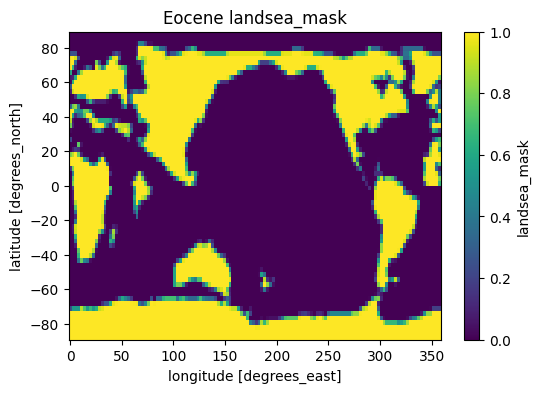

In [11]:
landsea_eocene = landsea["landsea_mask"]
plt.figure(figsize=(6,4))
landsea_eocene.plot()
plt.title("Eocene landsea_mask")
plt.show()

In [12]:
sd_orog["sd_orography"]

<xarray.DataArray 'sd_orography' (lat: 64, lon: 128)> Size: 33kB
[8192 values with dtype=float32]
Coordinates:
  * lon      (lon) float64 1kB 0.0 2.812 5.625 8.438 ... 348.8 351.6 354.4 357.2
  * lat      (lat) float64 512B 87.86 85.1 82.31 79.53 ... -82.31 -85.1 -87.86
Attributes:
    long_name:         Standard deviation of subgrid-scale paleotopography
    units:             m
    CDI_grid_type:     gaussian
    CDI_grid_num_LPE:  32

## 3. Prepare present-day land-sea mask (needed for albedo & vegetation)


→ Reading land-sea mask from /lus/h2resw01/hpcperm//ecme3497/ECE-DATA/oifs/TL63L31/17000101/ICMGGECE4INIT
Land-sea mask prepared with shape (64, 128) and dims ('lat', 'lon')


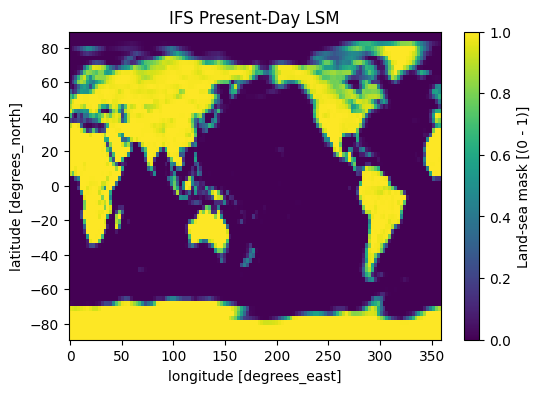

In [13]:
lsm_present = eocene.prepare_landsea_mask_present()
plt.figure(figsize=(6,4))
lsm_present.plot()
plt.title("IFS Present-Day LSM")
plt.show()


## 4. Run Eocene transformations


In [14]:
eocene.create_climate(lsm_present=lsm_present, landsea=landsea)
eocene.create_sh(orog=orog['orography'])
eocene.create_init(landsea["landsea_mask"], sd_orog["sd_orography"])
eocene.create_iniua()
#eocene.create_sic()
#eocene.create_sst()
eocene.aerosols()


Converting to netcdf file /lus/h2resw01/hpcperm//ecme3497/ECE-DATA/oifs/TL63L31/climate.v020/ICMCLECE4
Modifying GRIB file /lus/h2resw01/hpcperm//ecme3497/ECE-DATA/oifs/TL63L31/climate.v020/ICMCLECE4 using function albedo
Applying combined Albedo reconstruction + Eocene mask...


/lus/h2resw01/hpcperm/ecme3497/github/ecearth-quests/epochal/OIFS/eocene_functions.py:250: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  ntime = field.dims["time"]


Albedo reconstruction complete.
Eocene land-sea mask applied successfully.
Combined modification complete, GRIB structure preserved.
Converting back to GRIB file /etc/ecmwf/ssd/ssd1/tmpdirs/ecme3497.1826421.20260116_134435.721/cdoPyd_7sryo_
['grib_copy', '-w', 'shortName!=al,shortName!=aluvp,shortName!=aluvd,shortName!=alnip,shortName!=alnid,shortName!=lai_lv,shortName!=lai_hv', '/lus/h2resw01/hpcperm//ecme3497/ECE-DATA/oifs/TL63L31/climate.v020/ICMCLECE4', 'filtered.grib']
99990115
99990115
99990115
99990115
99990115
99990115
99990115
99990215
99990215
99990215
99990215
99990215
99990215
99990215
99990315
99990315
99990315
99990315
99990315
99990315
99990315
99990415
99990415
99990415
99990415
99990415
99990415
99990415
99990515
99990515
99990515
99990515
99990515
99990515
99990515
99990615
99990615
99990615
99990615
99990615
99990615
99990615
99990715
99990715
99990715
99990715
99990715
99990715
99990715
99990815
99990815
99990815
99990815
99990815
99990815
99990815
99990915
99990915

'/lus/h2resw01/hpcperm/ecme3497/ECE-DATA-EOC/oifs/ifsdata/aerosol_cams_climatology_43R3a.nc'

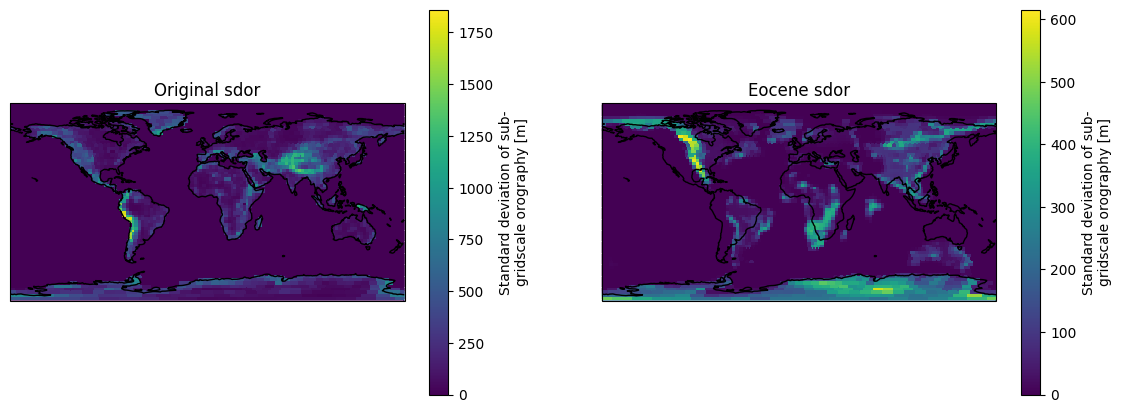

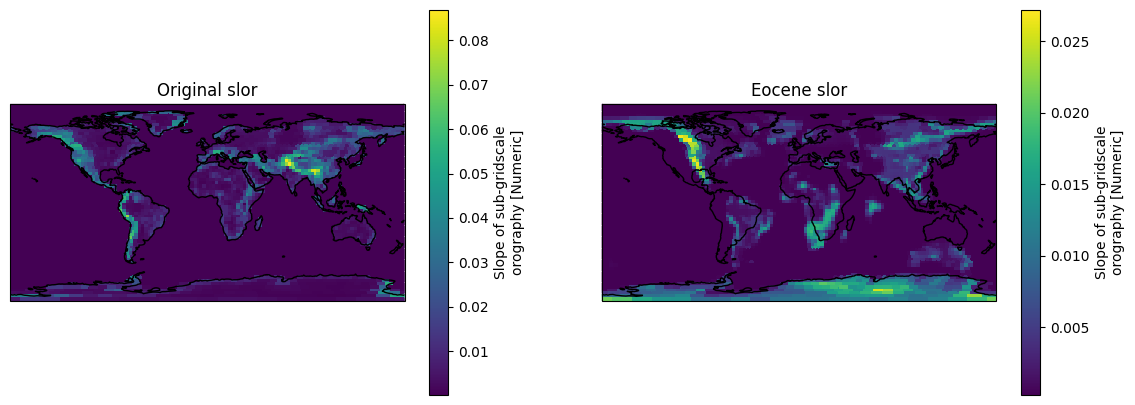

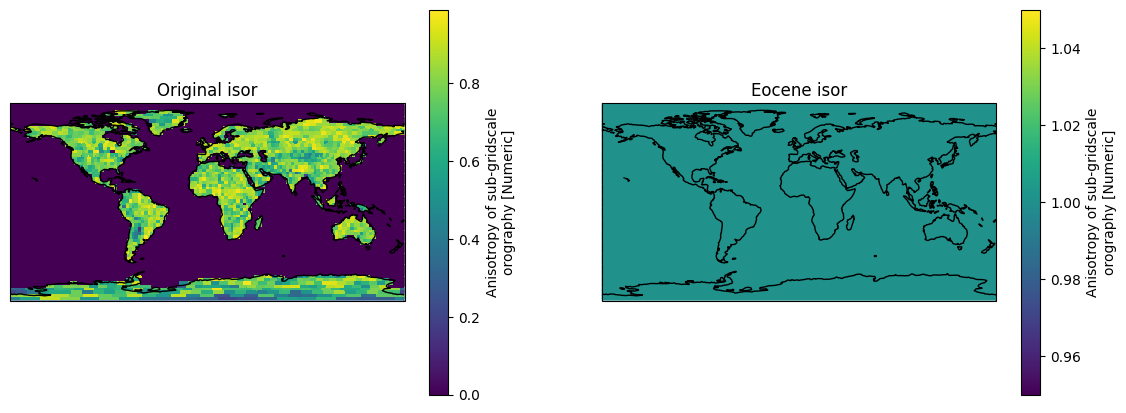

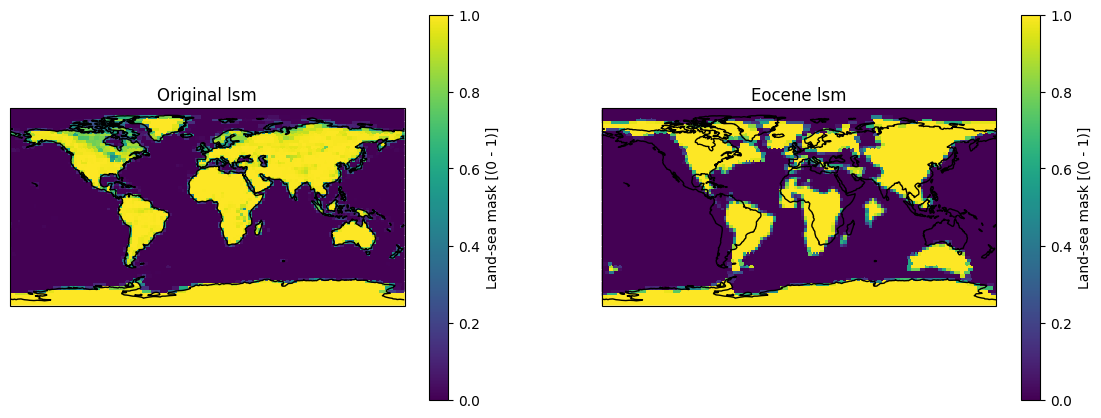

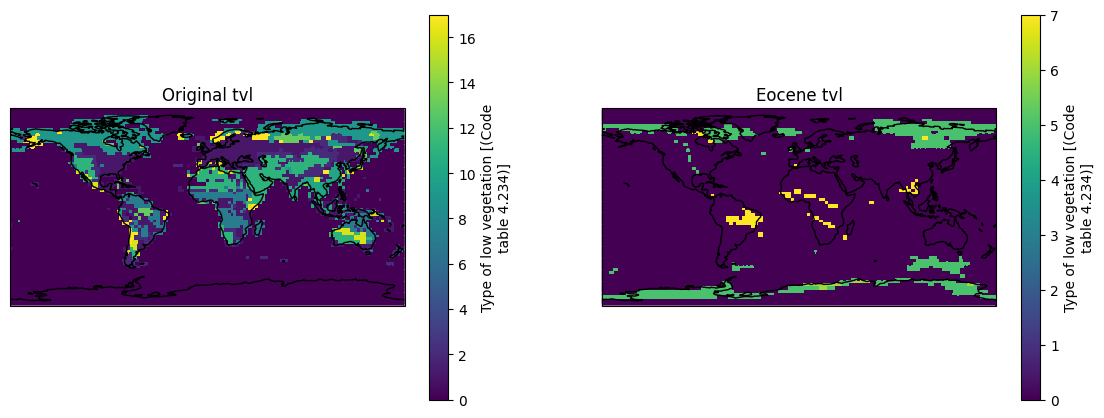

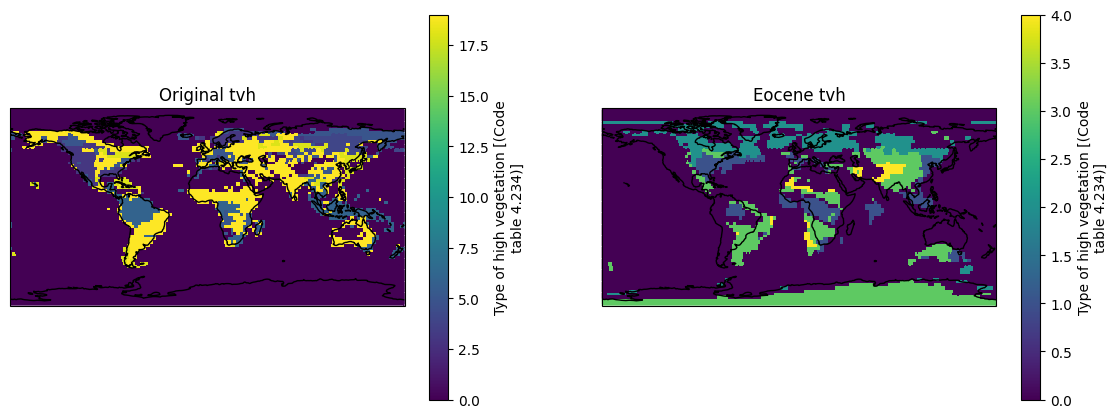

In [15]:
orig = os.path.join(eocene.idir_init, "ICMGGECE4INIT")
new  = os.path.join(eocene.odir_init, "ICMGGECE4INIT")

compare_maps("sdor", orig, new)   # subgrid orography
compare_maps("slor", orig, new)   # slope
compare_maps("isor", orig, new)   # anysotropy
compare_maps("lsm", orig, new)    # land-sea mask
compare_maps("tvl", orig, new)    # vegetation low
compare_maps("tvh", orig, new)    # vegetation high


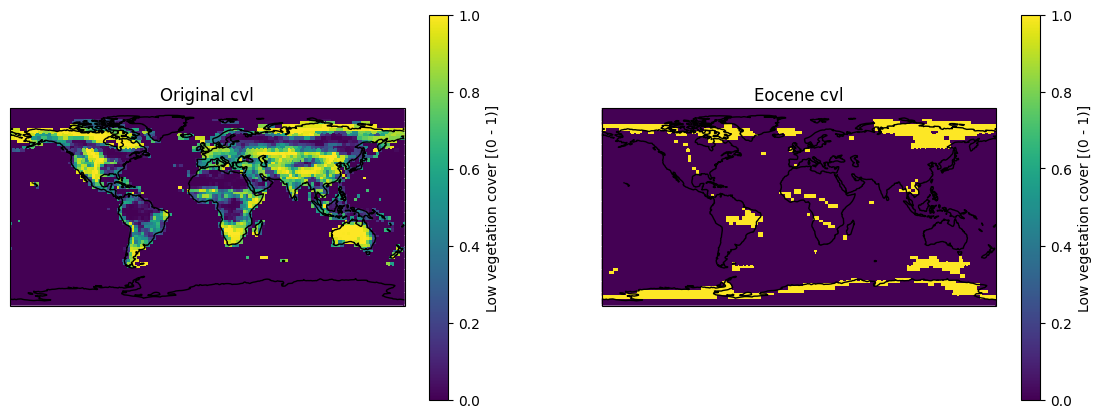

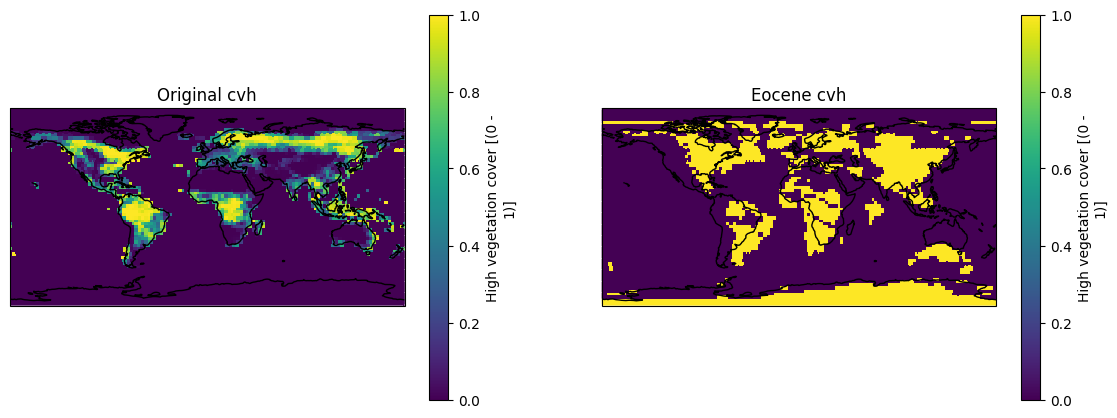

In [25]:
compare_maps("cvl", orig, new)    # vegetation low
compare_maps("cvh", orig, new)    # vegetation high

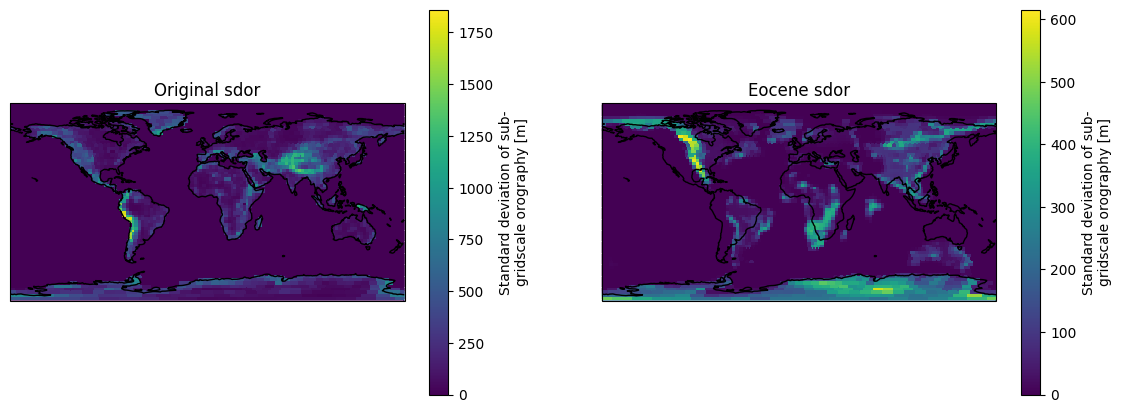

In [32]:
orig = os.path.join(eocene.idir_init, "ICMGGECE4INIT")
new  = os.path.join(eocene.odir_init, "ICMGGECE4INIT")
da_orig = load_grib_var(orig, "sdor")
da_new  = load_grib_var(new,  "sdor")

compare_maps("sdor", orig, new)

In [15]:
da = load_grib_var(orig, "sdor")
print(da.dims)
print(da.shape)
print(float(da.min()), float(da.max()))


('lat', 'lon')
(180, 360)
0.0 1859.90625


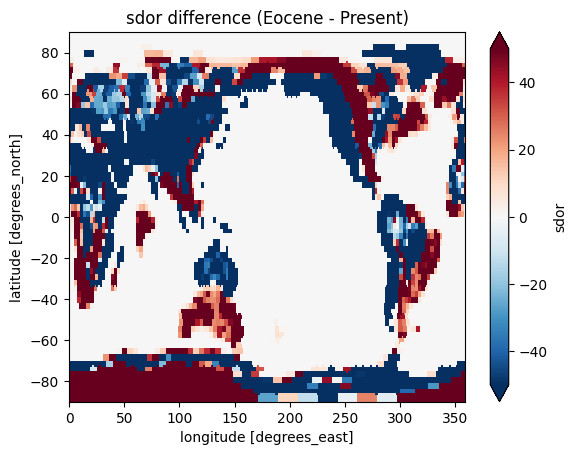

In [16]:
(da_new - da_orig).plot(
    cmap="RdBu_r",
    vmin=-50,
    vmax=50
)
plt.title("sdor difference (Eocene - Present)")
plt.show()


In [17]:
da_orig = load_grib_var(orig, "sdor")
da_new  = load_grib_var(new,  "sdor")

print("orig min/max:", float(da_orig.min()), float(da_orig.max()))
print("new  min/max:", float(da_new.min()),  float(da_new.max()))

print("difference RMS:",
      float(np.sqrt(((da_new - da_orig)**2).mean())))


orig min/max: 0.0 1859.90625
new  min/max: 0.0 615.84375
difference RMS: 195.3850860595703


## Orography (ICMSHECE4INIT)

Error in calling operator remapnn with:
>>> cdo -O -s -f nc4 -remapnn,r360x181 -selname,z /lus/h2resw01/hpcperm//ecme3497/ECE-DATA/oifs/TL63L31/19900101/ICMSHECE4INIT /etc/ecmwf/ssd/ssd1/tmpdirs/ecme3497.1156528.20260115_103346.832/tmpjlhdkji4.nc<<<
STDOUT:
STDERR:cdi  warning (gribapiScanTimestep1): Record 95 (name=z id=4.3.0 lev1=0 lev2=0) timestep 1: Inconsistent verification time!

cdo    remapnn (Abort): Unsupported spectral coordinates (Variable: z)!

Error in calling operator remapnn with:
>>> cdo -O -s -f nc4 -remapnn,r360x181 -selname,z /lus/h2resw01/hpcperm/ecme3497/ECE4-DATA-EOCENE/oifs/TL63L31/19900101/ICMSHECE4INIT /etc/ecmwf/ssd/ssd1/tmpdirs/ecme3497.1156528.20260115_103346.832/tmpi869038q.nc<<<
STDOUT:
STDERR:cdi  warning (gribapiScanTimestep1): Record 95 (name=z id=4.3.0 lev1=0 lev2=0) timestep 1: Inconsistent verification time!

cdo    remapnn (Abort): Unsupported spectral coordinates (Variable: z)!



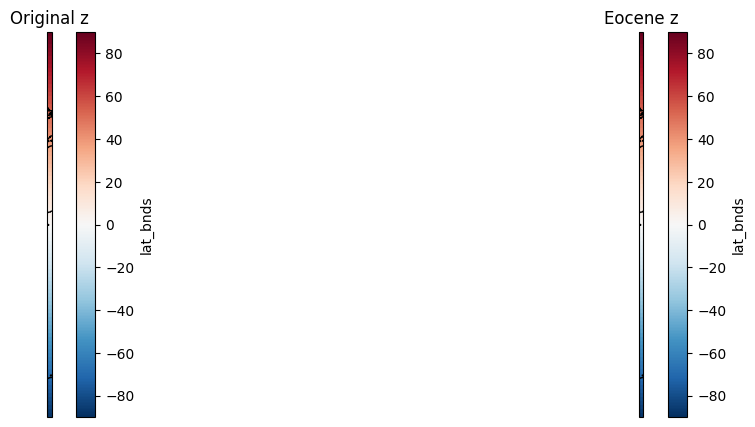

In [24]:
orig = os.path.join(eocene.idir_init, "ICMSHECE4INIT")
new  = os.path.join(eocene.odir_init, "ICMSHECE4INIT")

compare_maps("z", orig, new)   # geopotential


## Climate fields (ICMCLECE4)

In [16]:
orig

'/lus/h2resw01/hpcperm//ecme3497/ECE-DATA/oifs/TL63L31/climate.v020/ICMCLECE4'

In [17]:
new

'/lus/h2resw01/hpcperm/ecme3497/ECE-DATA-EOC/oifs/TL63L31/climate.v020/ICMCLECE4'

/etc/ecmwf/ssd/ssd1/tmpdirs/ecme3497.1367028.20260116_091532.069/ipykernel_3659934/3476989631.py:21: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  ds = xr.open_dataset(outfile)
/etc/ecmwf/ssd/ssd1/tmpdirs/ecme3497.1367028.20260116_091532.069/ipykernel_3659934/3476989631.py:21: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  ds = xr.open_dataset(outfile)


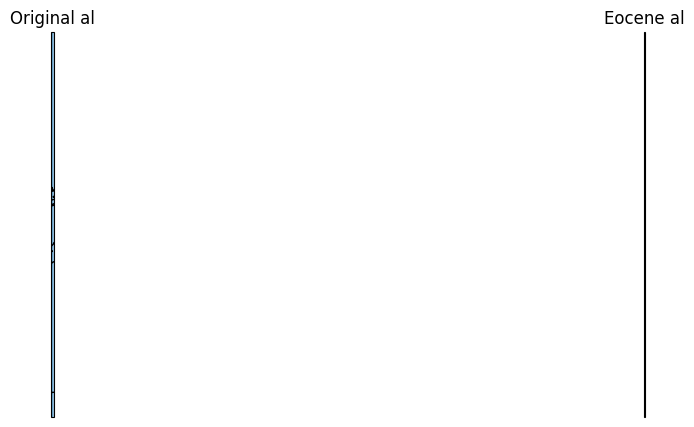

/etc/ecmwf/ssd/ssd1/tmpdirs/ecme3497.1367028.20260116_091532.069/ipykernel_3659934/3476989631.py:21: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  ds = xr.open_dataset(outfile)
/etc/ecmwf/ssd/ssd1/tmpdirs/ecme3497.1367028.20260116_091532.069/ipykernel_3659934/3476989631.py:21: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  ds = xr.open_dataset(outfile)


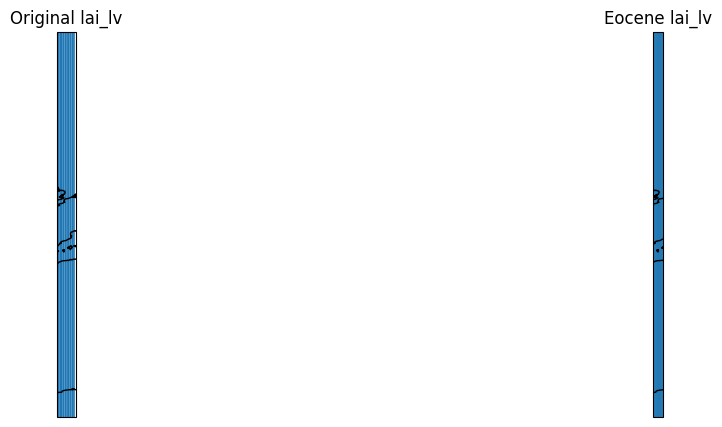

/etc/ecmwf/ssd/ssd1/tmpdirs/ecme3497.1367028.20260116_091532.069/ipykernel_3659934/3476989631.py:21: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  ds = xr.open_dataset(outfile)
/etc/ecmwf/ssd/ssd1/tmpdirs/ecme3497.1367028.20260116_091532.069/ipykernel_3659934/3476989631.py:21: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  ds = xr.open_dataset(outfile)


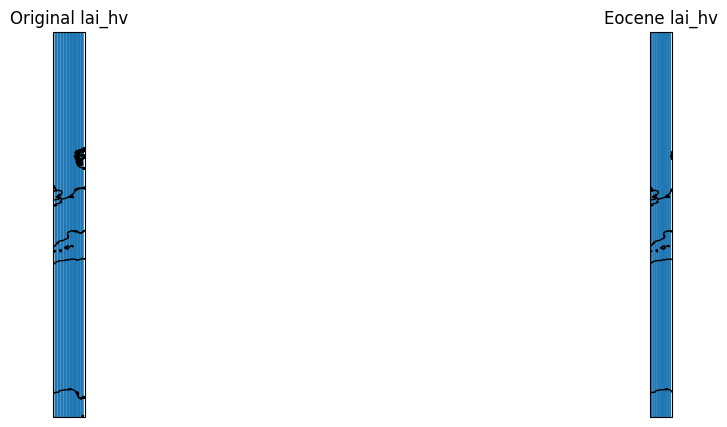

In [15]:
orig = os.path.join(eocene.idir_climate, "ICMCLECE4")
new  = os.path.join(eocene.odir_climate, "ICMCLECE4")

compare_maps("al", orig, new)
compare_maps("lai_lv", orig, new)
compare_maps("lai_hv", orig, new)

In [19]:
aerosols = eocene.aerosols()
print(f"Aerosols data saved at: {aerosols}")

→ Loading Herold aerosol data
→ Processing SO4 -> Sulfates
→ Processing CB1 -> Black_Carbon_hydrophilic
→ Processing CB2 -> Black_Carbon_hydrophobic
→ Processing DST01 -> Mineral_Dust_bin1
→ Processing DST02 -> Mineral_Dust_bin2
→ Processing DST03 -> Mineral_Dust_bin3
→ Processing OC1 -> Organic_Matter_hydrophilic
→ Processing OC2 -> Organic_Matter_hydrophobic
→ Processing SSLT01 -> Sea_Salt_bin1
→ Processing SSLT02 -> Sea_Salt_bin2
→ Processing SSLT03 -> Sea_Salt_bin3
→ Eocene aerosol data saved at /lus/h2resw01/hpcperm/ecme3497/ECE4-DATA-EOCENE/oifs/TL63L31/19900101/aerosol_cams_climatology_43R3a_EOCENO.nc
Aerosols data saved at: /lus/h2resw01/hpcperm/ecme3497/ECE4-DATA-EOCENE/oifs/TL63L31/19900101/aerosol_cams_climatology_43R3a_EOCENO.nc


In [20]:
aerosols_ds = xr.open_dataset(aerosols)

In [21]:
aerosols_ds

<xarray.Dataset> Size: 4MB
Dimensions:                     (lat: 61, lon: 120, month: 12)
Coordinates:
  * lat                         (lat) float32 244B 90.0 87.0 ... -87.0 -90.0
  * lon                         (lon) float32 480B 0.0 3.0 6.0 ... 354.0 357.0
Dimensions without coordinates: month
Data variables:
    Sulfates                    (month, lat, lon) float32 351kB ...
    Black_Carbon_hydrophilic    (month, lat, lon) float32 351kB ...
    Black_Carbon_hydrophobic    (month, lat, lon) float32 351kB ...
    Mineral_Dust_bin1           (month, lat, lon) float32 351kB ...
    Mineral_Dust_bin2           (month, lat, lon) float32 351kB ...
    Mineral_Dust_bin3           (month, lat, lon) float32 351kB ...
    Organic_Matter_hydrophilic  (month, lat, lon) float32 351kB ...
    Organic_Matter_hydrophobic  (month, lat, lon) float32 351kB ...
    Sea_Salt_bin1               (month, lat, lon) float32 351kB ...
    Sea_Salt_bin2               (month, lat, lon) float32 351kB ...
    Sea_Salt_bin3               (month, lat, lon) float32 351kB ...
Attributes:
    creation_date:  Sat 21 Jan 12:18:45 GMT 2017
    reference:      Reference for the CAMS-Interim reanalysis and the control...
    author:         ECMWF - Alessio Bozzo
    source:         2003-2011 Control run (gbst) scaled to CAMS interim reana...
    title:          Aerosol climatology derived from CAMS system
    history:        Mon Jan 23 20:18:26 2017: /usr/local/apps//nco/4.0.8/LP64...
    comment:        This file is the same as aerosol_cams_climatology_43R3.nc...

In [22]:
list(aerosols_ds.data_vars)


['Sulfates',
 'Black_Carbon_hydrophilic',
 'Black_Carbon_hydrophobic',
 'Mineral_Dust_bin1',
 'Mineral_Dust_bin2',
 'Mineral_Dust_bin3',
 'Organic_Matter_hydrophilic',
 'Organic_Matter_hydrophobic',
 'Sea_Salt_bin1',
 'Sea_Salt_bin2',
 'Sea_Salt_bin3']

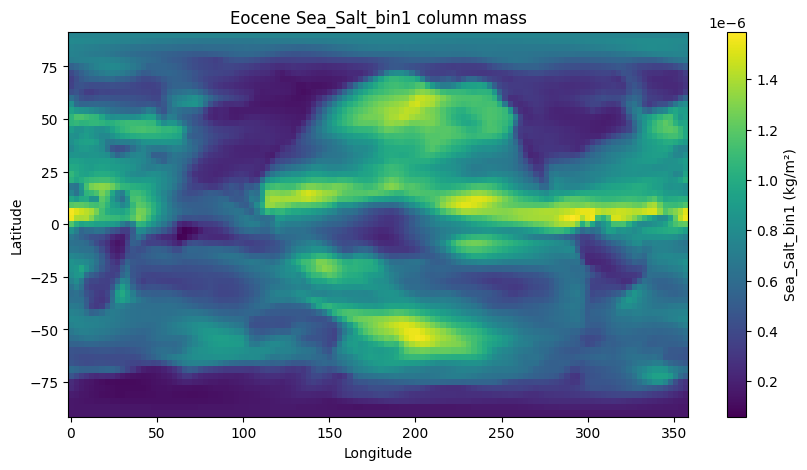

In [23]:
var_to_plot = 'Sea_Salt_bin1'
da = aerosols_ds[var_to_plot].isel(month=0)

plt.figure(figsize=(10,5))
im = plt.pcolormesh(da.lon, da.lat, da, shading='auto', cmap='viridis')
plt.colorbar(im, label=f"{var_to_plot} (kg/m²)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title(f"Eocene {var_to_plot} column mass")
plt.show()

In [20]:
eocene.create_init(landsea=landsea, sd_orog=sd_orog["sd_orography"])

Converting to netcdf file /lus/h2resw01/hpcperm//ecme3497/ECE-DATA/oifs/TL63L31/19900101/ICMGGECE4INIT
Modifying GRIB file /lus/h2resw01/hpcperm//ecme3497/ECE-DATA/oifs/TL63L31/19900101/ICMGGECE4INIT using function replace_value
Replacing variable lsm in the field


AttributeError: 'Dataset' object has no attribute 'data'

In [3]:
# Prepare the present-day land-sea mask
lsm_present = eocene.prepare_landsea_mask_present()

→ Reading land-sea mask from /lus/h2resw01/hpcperm//ecme3497/ece4-database/oifs/TL63L31/19900101/ICMGGECE4INIT
Land-sea mask prepared with shape (64, 128) and dims ('lat', 'lon')


In [4]:
landsea=landsea['landsea_mask']

In [5]:
eocene.create_climate(lsm_present, landsea)

Converting to netcdf file /lus/h2resw01/hpcperm//ecme3497/ece4-database/oifs/TL63L31/climate.v020/ICMCLECE4
Modifying GRIB file /lus/h2resw01/hpcperm//ecme3497/ece4-database/oifs/TL63L31/climate.v020/ICMCLECE4 using function albedo
Applying combined Albedo reconstruction + Eocene mask...
Albedo reconstruction complete.
Eocene land-sea mask applied successfully.
Combined modification complete, GRIB structure preserved.
Converting back to GRIB file /etc/ecmwf/ssd/ssd1/tmpdirs/ecme3497.2288646.20251028_131640.157/cdoPyw_jcxzdl


/lus/h2resw01/hpcperm/ecme3497/github/ecearth-quests/epochal/OIFS/albedo.py:44: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  ntime = field.dims["time"]


<xarray.Dataset> Size: 3MB
Dimensions:  (time: 12, lon: 128, lat: 64)
Coordinates:
  * time     (time) object 96B 9999-01-15 00:00:00 ... 9999-12-15 00:00:00
  * lon      (lon) float64 1kB 0.0 2.812 5.625 8.438 ... 348.8 351.6 354.4 357.2
  * lat      (lat) float64 512B 87.86 85.1 82.31 79.53 ... -82.31 -85.1 -87.86
Data variables:
    al       (time, lat, lon) float32 393kB ...
    aluvp    (time, lat, lon) float32 393kB ...
    aluvd    (time, lat, lon) float32 393kB ...
    alnip    (time, lat, lon) float32 393kB ...
    alnid    (time, lat, lon) float32 393kB ...
    lai_lv   (time, lat, lon) float32 393kB ...
    lai_hv   (time, lat, lon) float32 393kB ...
Attributes:
    CDI:          Climate Data Interface version 2.5.0 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    institution:  European Centre for Medium-Range Weather Forecasts
    history:      Tue Oct 28 15:56:53 2025: cdo -O -s -f nc4 -remapnn,N32 -se...
    CDO:          Climate Data Operators version 2.5.0 (https:

/etc/ecmwf/ssd/ssd1/tmpdirs/ecme3497.2288646.20251028_131640.157/ipykernel_3894585/1615466590.py:35: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  icmcl_remap = xr.open_dataset("/lus/h2resw01/hpcperm/ecme3497/ece4-database-eoc/oifs/TL63L31/climate.v020/ICMCLECE4_remap.nc")


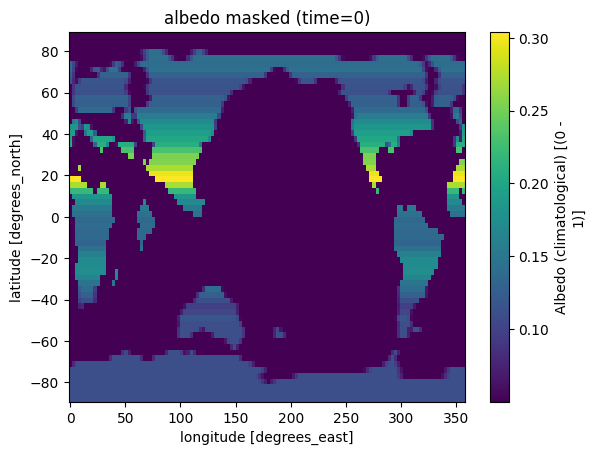

Temporary file 'ICMCLECE4_remap.nc' deleted successfully.


In [6]:
# 1- Load libraries
import os
import xarray as xr
import numpy as np
from cdo import Cdo
from utils import modify_value, replace_value
from utils import extract_grid_info, spectral2gaussian
import shutil
import tempfile
import matplotlib.pyplot as plt
from utils import GRIB2, NC4
cdo = Cdo()

icmcl_file = "/home/ecme3497/hpcperm/ece4-database-eoc/oifs/TL63L31/climate.v020/ICMCLECE4"
icmcl_remap = "/lus/h2resw01/hpcperm/ecme3497/ece4-database-eoc/oifs/TL63L31/climate.v020/ICMCLECE4_remap.nc"

# 3- Grid configuration
resolution = "TL63L31"
kind, spectral, _ = extract_grid_info(resolution)
gaussian = spectral2gaussian(spectral, kind)

# 4- Transform GRIB to NetCDF
for infile, outfile in [(icmcl_file,
                         icmcl_remap)]:
    if os.path.exists(outfile):
        os.remove(outfile)
    cdo.remapnn(
        f"N{gaussian}",
        input=f"-setgridtype,regular {infile}",
        output=outfile,
        options="-f nc4"
    )

# 5- Abro el archivo icmcl remapeado 
icmcl_remap = xr.open_dataset("/lus/h2resw01/hpcperm/ecme3497/ece4-database-eoc/oifs/TL63L31/climate.v020/ICMCLECE4_remap.nc") 

# Mostrar información general 
print(icmcl_remap)

icmcl_remap['al'].isel(time=5).plot(cmap='viridis')

plt.title("albedo masked (time=0)")
plt.show()

# Delete the temporary remapped file
os.remove("/lus/h2resw01/hpcperm/ecme3497/ece4-database-eoc/oifs/TL63L31/climate.v020/ICMCLECE4_remap.nc")
print("Temporary file 'ICMCLECE4_remap.nc' deleted successfully.")

In [13]:
eocene.create_sic()
eocene.create_sst()

In [14]:

orog = xr.open_dataset(eocene.prepare_herold(flag="orography"))
eocene.create_sh(orog=orog['orography'], )

eocene.create_iniua()

Converting to netcdf file /lus/h2resw01/hpcperm//ecme3497/ece4-database/oifs/TL63L31/19900101/ICMSHECE4INIT
Modifying GRIB file /lus/h2resw01/hpcperm//ecme3497/ece4-database/oifs/TL63L31/19900101/ICMSHECE4INIT using function replace_value
Replacing variable z in the field
Converting back to GRIB file /etc/ecmwf/ssd/ssd1/tmpdirs/ecme3497.1202079.20250528_120508.975/cdoPyctchtj1x
t,d,vo,lnsp
Converting to netcdf file /lus/h2resw01/hpcperm//ecme3497/ece4-database/oifs/TL63L31/19900101/ICMGGECE4INIUA
Modifying GRIB file /lus/h2resw01/hpcperm//ecme3497/ece4-database/oifs/TL63L31/19900101/ICMGGECE4INIUA using function modify_value
Modifying variable q in the field
Converting back to GRIB file /etc/ecmwf/ssd/ssd1/tmpdirs/ecme3497.1202079.20250528_120508.975/cdoPyg1neyl84


In [17]:
orog = xr.open_dataset(os.path.join(herold_dir, 'orography_remap.nc'))
landsea = xr.open_dataset(os.path.join(herold_dir, 'landsea_mask_remap.nc'))

In [19]:

def generate_seasonal_sst(inputfile, outputfile, A=25, OFFSET=20, T0=5):
    """
    Generate a seasonal SST latitudinal pattern and save it to a netCDF file.
    Parameters:
    - inputfile: Path to the input netCDF file.
    - outputfile: Path to the output netCDF file.
    - A: Amplitude of the latitudinal SST pattern.
    - OFFSET: Phase offset in degree for the seasonal pattern.
    - T0: Mean temperature.
    """

    sstfield = xr.open_dataset(inputfile)
    sstfield['tosbcs'].shape
    lons = sstfield['lon'].values
    lats = sstfield['lat'].values
    lon2d, lat2d = np.meshgrid(lons, lats)

    # Sinusoidal parameters
    A = 25        # Amplitude in degrees Celsius
    #B = 5      # Amplitude in degrees Celsius
    #beta = 45    # Phase shift in degrees
    k_lat = np.pi / 180    # frequency in lat direction
    #k_lon = np.pi / 180 * 4    # frequency in lon direction
    T0 = 5       # Mean temperature
    OFFSET = 20

    seasonal = np.cos(np.linspace(0,2*np.pi,num=13))[:-1]* OFFSET

    # Create sinusoidal SST pattern
    sst_pattern = []
    for phasing in seasonal:
        sst_pattern.append(A * np.pow(np.cos(k_lat * lat2d + np.pi/180* phasing), 2) + T0) #+ B * np.sin(k_lon * lon2d + np.pi/180*beta) + T0
    sst_stack = np.stack(sst_pattern, axis=0)
    stacksize = sstfield['tosbcs'].shape[0]
    sst_broadcast = np.tile(sst_stack, ((stacksize+11)//12, 1, 1))[:stacksize]
    sstfield['tosbcs'].data = sst_broadcast
    #sst_broadcast = np.broadcast_to(sst_stack, sstfield['tosbcs'].shape)
    #(sstfield['tosbcs'].isel(time=6)-sstfield['tosbcs'].isel(time=0)).plot()
    if os.path.exists(outputfile):
        os.remove(outputfile)
    sstfield.to_netcdf(outputfile)

generate_seasonal_sst(
    inputfile=os.path.join(amip_indir, 'tosbcs_input4MIPs_SSTsAndSeaIce_CMIP_PCMDI-AMIP-1-1-3_gn_187001-201706.nc'),
    outputfile=os.path.join(amip_outdir, 'tosbcs_input4MIPs_SSTsAndSeaIce_CMIP_PCMDI-AMIP-1-1-3_gn_187001-201706.nc')
)


In [ ]:

# erase all orography
modify_single_grib(
    inputfile=os.path.join(indir,'ICMSHECE4INIT'),
    outputfile=os.path.join(outdir,'ICMSHECE4INIT'),
    variables='z',
    spectral=True,
    myfunction=replace_value,
    newfield=orog['orography']*9.81
    #myfunction=modify_value,
    #new_value=0. 
)

# truncate spectral variables to first harmonic (mean value)
truncate_grib_file(
    inputfile=os.path.join(outdir,'ICMSHECE4INIT'),
    variables=['t','d','vo','lnsp'],
    outputfile=os.path.join(outdir,'ICMSHECE4INIT'),
)

# erase all subgrid orography
modify_single_grib(
    inputfile=os.path.join(indir,'ICMGGECE4INIT'),
    outputfile=os.path.join(outdir,'ICMGGECE4INIT_temp'),
    variables=['anor', 'isor', 'slor', 'cl', 'chnk'],
    spectral=False,
    myfunction=modify_value,
    newvalue=0.  
)

# erase all subgrid orography
modify_single_grib(
    inputfile=os.path.join(outdir,'ICMGGECE4INIT_temp'),
    outputfile=os.path.join(outdir,'ICMGGECE4INIT_temp1'),
    variables=['slt'],
    spectral=False,
    myfunction=modify_value,
    newvalue=3 
)

modify_single_grib(
    inputfile=os.path.join(outdir,'ICMGGECE4INIT_temp1'),
    outputfile=os.path.join(outdir,'ICMGGECE4INIT'),
    variables=['lsm'],
    spectral=False,
    myfunction=replace_value,
    newfield=landsea['landsea_mask']
)

# set humidity to 0
# swlv1, swvl2, swvl3, swvl4 to be set 0
#
modify_single_grib(
    inputfile=os.path.join(indir,'ICMGGECE4INIUA'),
    outputfile=os.path.join(outdir,'ICMGGECE4INIUA'),
    variables='q',
    spectral=False,
    myfunction=modify_value,
    newvalue=0.  
)





Converting to netcdf file /lus/h2resw01/hpcperm/ccpd/ECE4-DATA/oifs/TL63L31/19900101/ICMSHECE4INIT
Modifying GRIB file /lus/h2resw01/hpcperm/ccpd/ECE4-DATA/oifs/TL63L31/19900101/ICMSHECE4INIT using function replace_value
Replacing variable z in the field
Converting back to GRIB file /lus/h2resw01/scratch/ccpd/cdoPye2wmemal
t,d,vo,lnsp
Converting to netcdf file /lus/h2resw01/hpcperm/ccpd/ECE4-DATA/oifs/TL63L31/19900101/ICMGGECE4INIT
Modifying GRIB file /lus/h2resw01/hpcperm/ccpd/ECE4-DATA/oifs/TL63L31/19900101/ICMGGECE4INIT using function modify_value
Modifying variable sdor in the field
Modifying variable anor in the field
Modifying variable isor in the field
Modifying variable slor in the field
Modifying variable cl in the field
Modifying variable chnk in the field
Modifying variable tvh in the field
Modifying variable tvl in the field
Modifying variable cvh in the field
Modifying variable cvl in the field
Converting back to GRIB file /lus/h2resw01/scratch/ccpd/cdoPyimakj1r9
Convertin

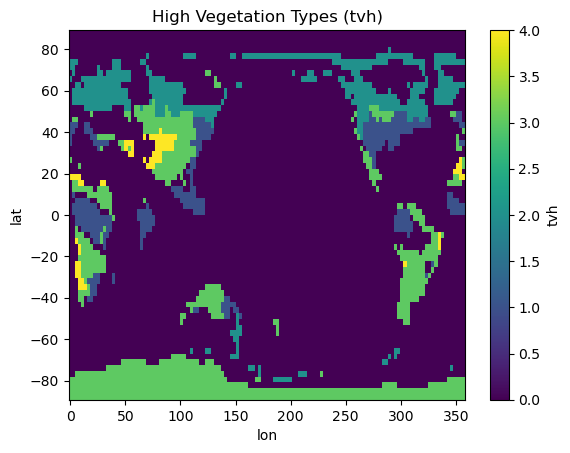

In [12]:
import matplotlib.pyplot as plt
veg = xr.open_dataset('/lus/h2resw01/hpcperm/ecme3497/ece4-database-eoc/oifs/TL63L31/19900101/ICMGG_vegetation.nc')
veg['tvh'].plot()
plt.title('High Vegetation Types (tvh)')
plt.show()

In [15]:
from eocene_functions import _to_tll
from utils import detect_grib_version

In [43]:
herold_file = os.path.join(eocene.herold, "herold_etal_eocene_biome_1x1.nc")
herold_remap = cdo.remapnn(
    f"N{eocene.gaussian}", 
    input=herold_file, 
    output=os.path.join(eocene.herold, "herold_etal_eocene_biome_1x1_N32.nc")
    )

herold = xr.open_dataset(herold_remap)

In [44]:
inputfile = os.path.join(eocene.idir_init, "ICMGGECE4INIT")
print (f"{inputfile}")    
# Define temporary NetCDF path
with tempfile.NamedTemporaryFile(suffix=".nc", delete=False) as tmp:
    field_remap = tmp.name

print(f"→ Reading vegetation from {field_remap}")

/lus/h2resw01/hpcperm//ecme3497/ECE-DATA/oifs/TL63L31/19900101/ICMGGECE4INIT
→ Reading vegetation from /etc/ecmwf/ssd/ssd1/tmpdirs/ecme3497.1367028.20260116_091532.069/tmpcph9za7k.nc


In [45]:
if os.path.exists(inputfile):
    print(f"Converting to netcdf file {inputfile}")

varlist=','.join(['tvh', 'tvl', 'cvh', 'cvl'])
singlefile = cdo.selname(varlist, input=inputfile, options="--eccodes")
grib_version = detect_grib_version(singlefile)
GRIB2="-f grb2 --eccodes"
GRIB1="-f grb1 --eccodes"
NC4='-f nc4 --eccodes'
spectral=False
# Convert to netcdf: if spectral use sp2gpl, else use setgridtype
if spectral:
    netcdf = cdo.sp2gpl(input=singlefile, options=NC4)
else:
    netcdf = cdo.setgridtype("regular", input=singlefile, options=NC4)

# open the netcdf and modify it
field = xr.open_dataset(netcdf,  engine="netcdf4", decode_times=False)

Converting to netcdf file /lus/h2resw01/hpcperm//ecme3497/ECE-DATA/oifs/TL63L31/19900101/ICMGGECE4INIT


In [46]:
field

<xarray.Dataset> Size: 133kB
Dimensions:  (time: 1, lon: 128, lat: 64)
Coordinates:
  * time     (time) float64 8B 0.0
  * lon      (lon) float64 1kB 0.0 2.812 5.625 8.438 ... 348.8 351.6 354.4 357.2
  * lat      (lat) float64 512B 87.86 85.1 82.31 79.53 ... -82.31 -85.1 -87.86
Data variables:
    cvh      (time, lat, lon) float32 33kB ...
    cvl      (time, lat, lon) float32 33kB ...
    tvh      (time, lat, lon) float32 33kB ...
    tvl      (time, lat, lon) float32 33kB ...
Attributes:
    CDI:          Climate Data Interface version 2.5.0 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    institution:  European Centre for Medium-Range Weather Forecasts
    history:      Fri Jan 16 09:46:10 2026: cdo -O -s -f nc4 --eccodes -setgr...
    CDO:          Climate Data Operators version 2.5.0 (https://mpimet.mpg.de...

In [47]:
# Convert GRIB to regular Gaussian NetCDF
cdo.remapnn(
    f"N{eocene.gaussian}",
    input=f"-setgridtype,regular {inputfile}",
    output=field_remap,
    options="-f nc4"
)
    
# Open the converted file and extract lsm
ds = xr.open_dataset(field_remap)

    

In [48]:
tvh = _to_tll(xr.full_like(field["tvh"], 0))
tvl = _to_tll(xr.full_like(field["tvl"], 0))

cvh = xr.zeros_like(tvh)
cvl = xr.zeros_like(tvl)

print("Initial shapes:")
print(f"tvh: {tvh.shape}, tvl: {tvl.shape}, cvh: {cvh.shape}, cvl: {cvl.shape}")

Initial shapes:
tvh: (1, 64, 128), tvl: (1, 64, 128), cvh: (1, 64, 128), cvl: (1, 64, 128)


In [49]:
# === Biome to vegetation ID mappings ===
biome_to_tvh = {
    1: 1, # Tropical forest → Evergreen broadleaf trees
    2: 2, # Warm-temperate forest → Evergreen needleleaf trees
    6: 3, # Temperate forest → Deciduous broadleaf
    7: 4, # Boreal forest → Deciduous needleleaf
}

biome_to_tvl = {
    3: 5, # Savanna → Tall grass
    4: 6, # Grassland → Short grass
    5: 7, # Desert → Semidesert
    8: 8, # Tundra → Tundra
    9: 8, # Dry Tundra → Tundra
}

In [50]:
for biome_id in range(1, 10): # assuming biome IDs go from 1 to 9
    mask = herold['eocene_biome_hp'] == biome_id
    # Expand mask to time dimension if present
    if 'time' in tvh.dims:
        mask = mask.expand_dims(time=tvh['time'])
    # Sanity check
    print(f"Biome {biome_id}: mask shape {mask.shape}")
    for arr_name, arr in zip(['tvh','tvl'], [tvh, tvl]):
        print(f"Array {arr_name} shape: {arr.shape}")
        if mask.shape != arr.shape:
            print(f"WARNING: mask shape {mask.shape} != {arr_name} shape {arr.shape}")
    

    if biome_id in biome_to_tvh:
        tvh = xr.where(mask, biome_to_tvh[biome_id], tvh)
        cvh = xr.where(mask, 1.0, cvh)
    elif biome_id in biome_to_tvl:
        tvl = xr.where(mask, biome_to_tvl[biome_id], tvl)
        cvl = xr.where(mask, 1.0, cvl)
    else:
        print(f"Warning: biome {biome_id} not in mapping.")

Biome 1: mask shape (1, 64, 128)
Array tvh shape: (1, 64, 128)
Array tvl shape: (1, 64, 128)
Biome 2: mask shape (1, 64, 128)
Array tvh shape: (1, 64, 128)
Array tvl shape: (1, 64, 128)
Biome 3: mask shape (1, 64, 128)
Array tvh shape: (1, 64, 128)
Array tvl shape: (1, 64, 128)
Biome 4: mask shape (1, 64, 128)
Array tvh shape: (1, 64, 128)
Array tvl shape: (1, 64, 128)
Biome 5: mask shape (1, 64, 128)
Array tvh shape: (1, 64, 128)
Array tvl shape: (1, 64, 128)
Biome 6: mask shape (1, 64, 128)
Array tvh shape: (1, 64, 128)
Array tvl shape: (1, 64, 128)
Biome 7: mask shape (1, 64, 128)
Array tvh shape: (1, 64, 128)
Array tvl shape: (1, 64, 128)
Biome 8: mask shape (1, 64, 128)
Array tvh shape: (1, 64, 128)
Array tvl shape: (1, 64, 128)
Biome 9: mask shape (1, 64, 128)
Array tvh shape: (1, 64, 128)
Array tvl shape: (1, 64, 128)


In [34]:
arr_name

'tvl'

In [35]:
tvh

<xarray.DataArray (time: 1, lat: 64, lon: 128)> Size: 33kB
array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [3., 3., 3., ..., 3., 3., 3.],
        [3., 3., 3., ..., 3., 3., 3.],
        [3., 3., 3., ..., 3., 3., 3.]]], dtype=float32)
Coordinates:
  * time     (time) float64 8B 0.0
  * lon      (lon) float64 1kB 0.0 2.812 5.625 8.438 ... 348.8 351.6 354.4 357.2
  * lat      (lat) float64 512B 87.86 85.1 82.31 79.53 ... -82.31 -85.1 -87.86

In [51]:
field

<xarray.Dataset> Size: 133kB
Dimensions:  (time: 1, lon: 128, lat: 64)
Coordinates:
  * time     (time) float64 8B 0.0
  * lon      (lon) float64 1kB 0.0 2.812 5.625 8.438 ... 348.8 351.6 354.4 357.2
  * lat      (lat) float64 512B 87.86 85.1 82.31 79.53 ... -82.31 -85.1 -87.86
Data variables:
    cvh      (time, lat, lon) float32 33kB ...
    cvl      (time, lat, lon) float32 33kB ...
    tvh      (time, lat, lon) float32 33kB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    tvl      (time, lat, lon) float32 33kB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
Attributes:
    CDI:          Climate Data Interface version 2.5.0 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    institution:  European Centre for Medium-Range Weather Forecasts
    history:      Fri Jan 16 09:46:10 2026: cdo -O -s -f nc4 --eccodes -setgr...
    CDO:          Climate Data Operators version 2.5.0 (https://mpimet.mpg.de...

In [53]:
# Final shape check before assignment
#for var_name, arr in zip(["tvh","tvl","cvh","cvl"], [tvh, tvl, cvh, cvl]):
#    print(f"Final {var_name} shape: {arr.shape}, field shape: {field[var_name].shape}")
#    if arr.shape != field[var_name].shape:
#        print(f"WARNING: {var_name} shape mismatch! {arr.shape} vs {field[var_name].shape}")


tvh = field["tvh"]
tvl = field["tvl"]
cvh = field["cvh"]
cvl = field["cvl"]

# modify tvh, tvl, cvh, cvl here
# (your biome loop)

field = field.assign(
    tvh=tvh,
    tvl=tvl,
    cvh=cvh,
    cvl=cvl,
)



# Replace field variables
#for var, newval in zip(["tvh", "tvl", "cvh", "cvl"], [tvh, tvl, cvh, cvl]):
#    field[var] = newval
    


In [54]:
field

<xarray.Dataset> Size: 133kB
Dimensions:  (time: 1, lon: 128, lat: 64)
Coordinates:
  * time     (time) float64 8B 0.0
  * lon      (lon) float64 1kB 0.0 2.812 5.625 8.438 ... 348.8 351.6 354.4 357.2
  * lat      (lat) float64 512B 87.86 85.1 82.31 79.53 ... -82.31 -85.1 -87.86
Data variables:
    cvh      (time, lat, lon) float32 33kB ...
    cvl      (time, lat, lon) float32 33kB ...
    tvh      (time, lat, lon) float32 33kB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    tvl      (time, lat, lon) float32 33kB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
Attributes:
    CDI:          Climate Data Interface version 2.5.0 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    institution:  European Centre for Medium-Range Weather Forecasts
    history:      Fri Jan 16 09:46:10 2026: cdo -O -s -f nc4 --eccodes -setgr...
    CDO:          Climate Data Operators version 2.5.0 (https://mpimet.mpg.de...

In [55]:
field[["tvh", "tvl", "cvh", "cvl"]]

<xarray.Dataset> Size: 133kB
Dimensions:  (time: 1, lat: 64, lon: 128)
Coordinates:
  * time     (time) float64 8B 0.0
  * lon      (lon) float64 1kB 0.0 2.812 5.625 8.438 ... 348.8 351.6 354.4 357.2
  * lat      (lat) float64 512B 87.86 85.1 82.31 79.53 ... -82.31 -85.1 -87.86
Data variables:
    tvh      (time, lat, lon) float32 33kB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    tvl      (time, lat, lon) float32 33kB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    cvh      (time, lat, lon) float32 33kB ...
    cvl      (time, lat, lon) float32 33kB ...
Attributes:
    CDI:          Climate Data Interface version 2.5.0 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    institution:  European Centre for Medium-Range Weather Forecasts
    history:      Fri Jan 16 09:46:10 2026: cdo -O -s -f nc4 --eccodes -setgr...
    CDO:          Climate Data Operators version 2.5.0 (https://mpimet.mpg.de...

In [59]:
field [['tvh', 'tvl']]

<xarray.Dataset> Size: 67kB
Dimensions:  (time: 1, lat: 64, lon: 128)
Coordinates:
  * time     (time) float64 8B 0.0
  * lon      (lon) float64 1kB 0.0 2.812 5.625 8.438 ... 348.8 351.6 354.4 357.2
  * lat      (lat) float64 512B 87.86 85.1 82.31 79.53 ... -82.31 -85.1 -87.86
Data variables:
    tvh      (time, lat, lon) float32 33kB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    tvl      (time, lat, lon) float32 33kB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
Attributes:
    CDI:          Climate Data Interface version 2.5.0 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    institution:  European Centre for Medium-Range Weather Forecasts
    history:      Fri Jan 16 09:46:10 2026: cdo -O -s -f nc4 --eccodes -setgr...
    CDO:          Climate Data Operators version 2.5.0 (https://mpimet.mpg.de...